# Find the example case

In [1]:
import os
import sys
import xarray as xr
import numpy as np
from glob import glob

In [85]:
from numba import njit

RVGAS = 461.5  # J/kg/K
RDGAS = 287.05  # J/kg/K

#@njit
def create_pressure_grid(surface_pressure, model_a, model_b):
    """
    Create a 3D pressure field at model levels from the surface pressure field and the hybrid sigma-pressure
    coefficients from ECMWF. Conversion is `pressure_3d = a + b * SP`.

    Args:
        surface_pressure (np.ndarray): (time, latitude, longitude) or (latitude, longitude) grid in units of Pa.
        model_a (np.ndarray): a coefficients at each model level being used in units of Pa.
        model_b (np.ndarray): b coefficients at each model level being used (unitness).

    Returns:
        pressure_3d: 3D pressure field with dimensions of surface_pressure and number of levels from model_a and model_b.
    """
    assert (
        model_a.size == model_b.size
    ), "Model pressure coefficient arrays do not match."
    if surface_pressure.ndim == 3:
        # Generate the 3D pressure field for a time series of surface pressure grids
        pressure_3d = np.zeros(
            (
                surface_pressure.shape[0],
                model_a.shape[0],
                surface_pressure.shape[1],
                surface_pressure.shape[2],
            ),
            dtype=surface_pressure.dtype,
        )
        model_a_3d = model_a.reshape(-1, 1, 1)
        model_b_3d = model_b.reshape(-1, 1, 1)
        for i in range(surface_pressure.shape[0]):
            pressure_3d[i] = model_a_3d + model_b_3d * surface_pressure[i]
    else:
        # Generate the 3D pressure field for a single surface pressure grid.
        model_a_3d = model_a.reshape(-1, 1, 1)
        model_b_3d = model_b.reshape(-1, 1, 1)
        pressure_3d = model_a_3d + model_b_3d * surface_pressure
    return pressure_3d

#@njit
def geopotential_from_model_vars(
    surface_geopotential, surface_pressure, temperature, mixing_ratio, model_a, model_b
):
    
    gamma = RVGAS / RDGAS - 1.0
    half_a = 0.5 * (model_a[:-1] + model_a[1:])
    half_b = 0.5 * (model_b[:-1] + model_b[1:])
    model_pressure = create_pressure_grid(surface_pressure, model_a, model_b)
    half_pressure = create_pressure_grid(surface_pressure, half_a, half_b)
    model_geopotential = np.zeros(model_pressure.shape, dtype=surface_pressure.dtype)
    half_geopotential = np.zeros(half_pressure.shape, dtype=surface_pressure.dtype)
    virtual_temperature = temperature * (1.0 + gamma * mixing_ratio)
    m = model_geopotential.shape[-3] - 1
    h = half_geopotential.shape[-3] - 1
    model_geopotential[m] = surface_geopotential + RDGAS * virtual_temperature[
        m
    ] * np.log(surface_pressure / model_pressure[m])
    for i in range(1, model_geopotential.shape[-3]):
        half_geopotential[h] = model_geopotential[m] + RDGAS * virtual_temperature[
            m
        ] * np.log(model_pressure[m] / half_pressure[h])
        m -= 1
        model_geopotential[m] = half_geopotential[h] + RDGAS * virtual_temperature[
            m
        ] * np.log(half_pressure[h] / model_pressure[m])
        h -= 1
    return model_geopotential

In [68]:
ds_static = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/static/ERA5_mlevel_1deg_static_for_interp.zarr'
)

In [89]:
coef_a_mid = ds_static['coef_a_mid'].values
coef_b_mid = ds_static['coef_b_mid'].values
GPH = ds_static['geopotential_at_surface'].values[20:60, 210:300]

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
fn_plevel = sorted(
    glob(
        '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/upper_subset/ERA5_subset_1deg_6h_*_conserve.zarr'
    )
)

fn_mlevel = sorted(
    glob(
        '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/all_in_one/ERA5_mlevel_1deg_6h_subset_*_conserve.zarr'
    )
)

In [8]:
fn_plevel_example = fn_plevel[41]
ds_plevel_example = xr.open_zarr(fn_plevel_example)

fn_mlevel_example = fn_mlevel[41]
ds_mlevel_example = xr.open_zarr(fn_mlevel_example)

In [103]:
latitude = ds_example['latitude'].values[20:60]
longitude = ds_example['longitude'].values[210:300] - 360
gridx, gridy = np.meshgrid(longitude, latitude)

In [114]:
i_time = 55

In [129]:
T_plevel = ds_plevel_example['T'].isel(level=-6, time=i_time).values[20:60, 210:300]
Z_plevel = ds_plevel_example['Z'].isel(level=-6, time=i_time).values[20:60, 210:300]
q_plevel = ds_plevel_example['specific_total_water'].isel(level=-6, time=i_time).values[20:60, 210:300]
U_plevel = ds_plevel_example['U'].isel(level=-6, time=i_time).values[20:60, 210:300]
V_plevel = ds_plevel_example['V'].isel(level=-6, time=i_time).values[20:60, 210:300]

T_mlevel = ds_mlevel_example['temperature'].isel(time=i_time).values[:, 20:60, 210:300]
q_mlevel = ds_mlevel_example['specific_total_water'].isel(time=i_time).values[:, 20:60, 210:300]
SP_mlevel = ds_mlevel_example['SP'].isel(time=i_time).values[20:60, 210:300]

Z_mlevel = geopotential_from_model_vars(
    GPH, SP_mlevel, T_mlevel, q_mlevel, coef_a_mid, coef_b_mid
)

U_mlevel = ds_mlevel_example['u_component_of_wind'].isel(time=i_time).values[:, 20:60, 210:300]
V_mlevel = ds_mlevel_example['v_component_of_wind'].isel(time=i_time).values[:, 20:60, 210:300]

In [130]:
# Z_plevel = ds_plevel_example['Z'].isel(level=-6).values[:, 20:60, 210:300]
# Z_plevel.shape

In [131]:
# for i_time in range(1464):
#     plt.figure()
#     plt.contour(gridx, gridy, Z_plevel[i_time])
#     plt.title(f'time index = {i_time}', fontsize=14)

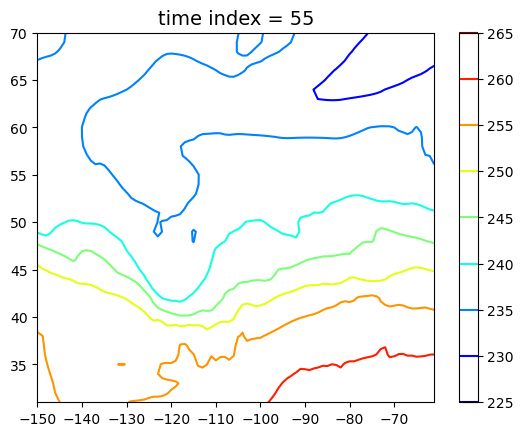

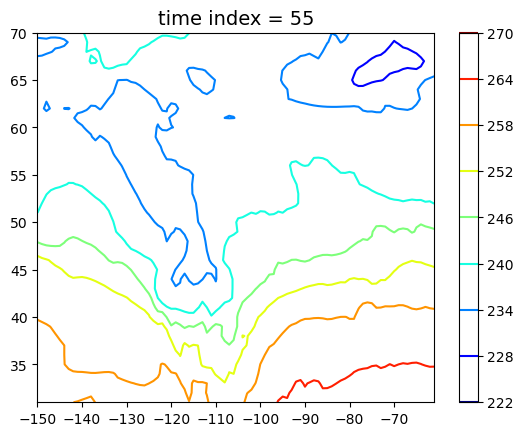

In [135]:
# for i_time in range(1464):
i_mlevel = -8

plt.figure()
plt.contour(gridx, gridy, T_plevel, cmap=plt.cm.jet)
plt.title(f'time index = {i_time}', fontsize=14)
plt.colorbar()

plt.figure()
plt.contour(gridx, gridy, T_mlevel[i_mlevel, ...], cmap=plt.cm.jet)
plt.title(f'time index = {i_time}', fontsize=14)
plt.colorbar()

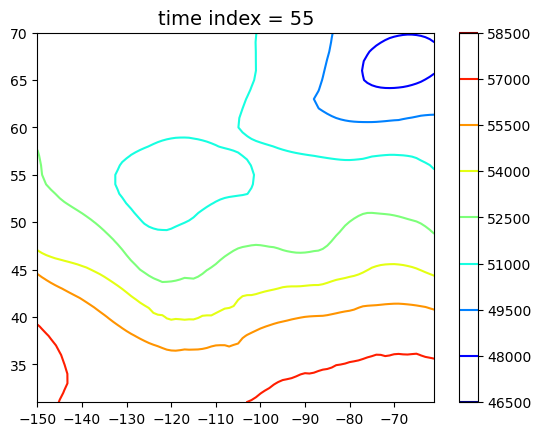

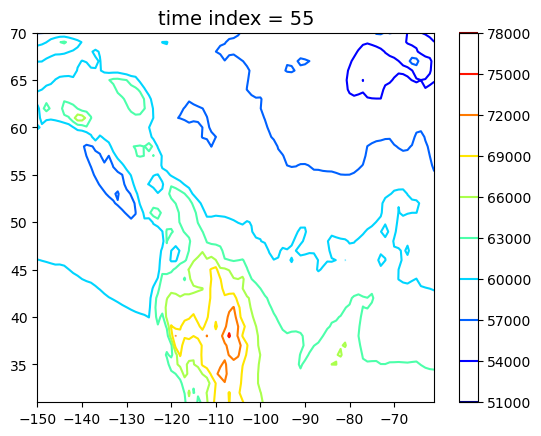

In [119]:
# for i_time in range(1464):
i_mlevel = -8

plt.figure()
plt.contour(gridx, gridy, Z_plevel, cmap=plt.cm.jet)
plt.title(f'time index = {i_time}', fontsize=14)
plt.colorbar()

plt.figure()
plt.contour(gridx, gridy, Z_mlevel[i_mlevel, ...], cmap=plt.cm.jet)
plt.title(f'time index = {i_time}', fontsize=14)
plt.colorbar()

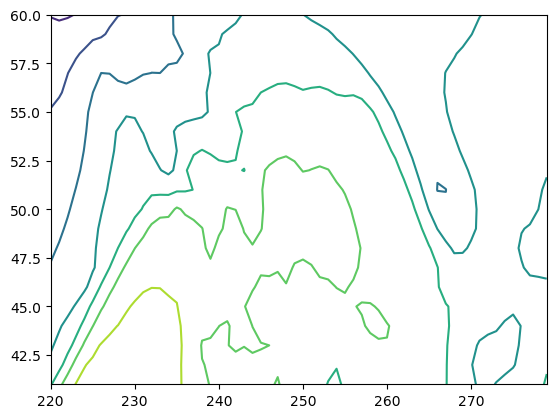

In [16]:
plt.figure()

plt.contour(gridx, gridy, T_mlevel[time_pick, ...])

In [22]:
# for i_time in range(1464):
#     if np.max(TP[i_time, ...]) > 0.025:
#         fig, ax = plt.subplots(figsize=(7, 3))
    
#         cf = ax.pcolormesh(gridx, gridy, TP[i_time, ...], cmap=plt.cm.nipy_spectral_r)
#         cbar = fig.colorbar(cf, ax=ax, label='TP')
        
#         skip = (slice(None, None, 3), slice(None, None, 3))
#         U_quiv = U[i_time, ...][skip]
#         V_quiv = V[i_time, ...][skip]
#         gridx_quiv = gridx[skip]
#         gridy_quiv = gridy[skip]
        
#         # Overlay the horizontal wind vectors as quiver arrows.
#         ax.quiver(gridx_quiv, gridy_quiv, U_quiv, V_quiv,
#                   color='k', scale=300)
        
#         ax.set_title(f'time index = {i_time}', fontsize=14)